In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in resonator data
df = pd.read_csv('IdealResonator_CAP.csv', sep=" ", skiprows=5)
df.head()

,!Freq,DBS11,AngS11,DBS21,AngS21,DBS12,AngS12,DBS22,AngS22,Unnamed: 9
0,4.000,-0.000362,-0.382208,-87.335502,-166.05402,-87.335502,-166.05402,-0.000362,-0.382208,NaN
1,4.002,-0.000362,-0.382399,-87.326395,-166.06518,-87.326395,-166.06518,-0.000362,-0.382399,NaN
2,4.004,-0.000362,-0.382590,-87.317292,-166.07632,-87.317292,-166.07632,-0.000362,-0.382590,NaN
3,4.006,-0.000363,-0.382781,-87.308195,-166.08746,-87.308195,-166.08746,-0.000363,-0.382781,NaN
4,4.008,-0.000363,-0.382972,-87.299102,-166.09859,-87.299102,-166.09859,-0.000363,-0.382972,NaN


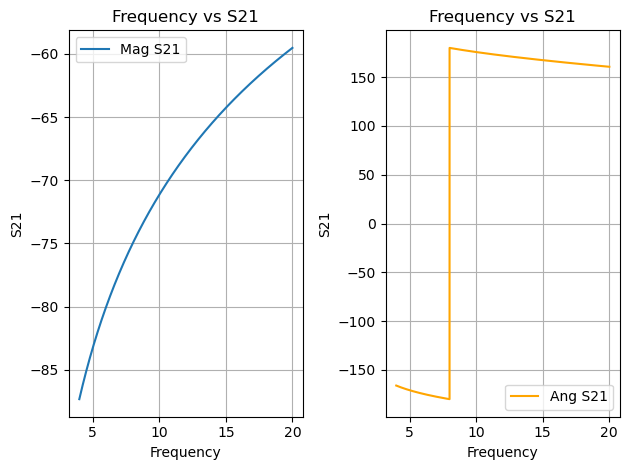

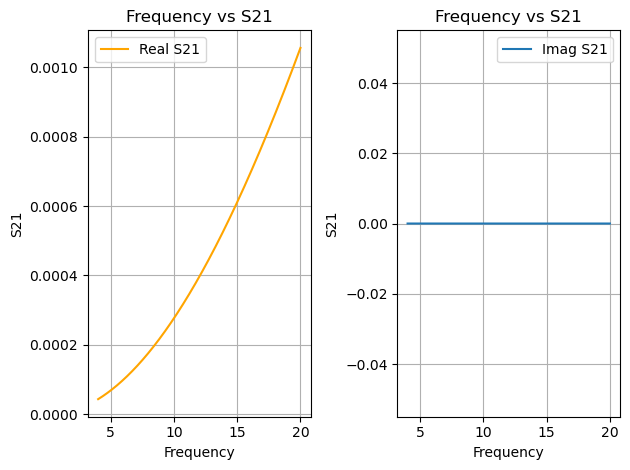

In [3]:
# Plot transmission data from dataframe
def plot_S21(df, magn=True, unwrap = False):
    # Plot frequency versus S21
    fig, (ax1, ax2) = plt.subplots(1, 2)

    if unwrap == True:
        freq = np.unwrap(df['!Freq'])
    else:
        freq = df['!Freq']

    if magn == True:
        ax1.plot(freq, df['DBS21'], label='Mag S21')
        ax2.plot(freq, df['AngS21'], color='orange', label='Ang S21')
    else:
        ampl = 10**(df['DBS21']/20)  # convert S21 dBm to linear
        real = np.real(ampl)
        imag = np.imag(ampl)        
        ax1.plot(freq, real, label='Real S21', color='orange')
        ax2.plot(freq, imag, label='Imag S21')

    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('S21')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('S21')
    ax1.set_title('Frequency vs S21')
    ax2.set_title('Frequency vs S21')
    ax1.legend()
    ax2.legend()
    ax1.grid(True)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_S21(df)

plot_S21(df, magn=False)

In [4]:
# Add gaussian noise to transmission data
def add_gaussian_noise(df, mean=0, std=0.1, column='DBS21'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_noisy = df.copy()
    # Add Gaussian noise to the specified column
    noise = np.random.normal(mean, std, len(df_noisy))
    df_noisy[column] += noise # + (1j * noise) # For if imaginary values

    return df_noisy

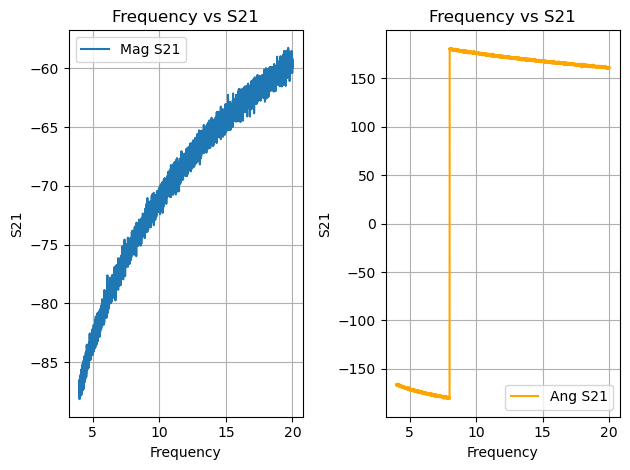

In [5]:
df_noisy = add_gaussian_noise(df, mean=0, std=0.5)
df_noisy = add_gaussian_noise(df_noisy, mean=0, std=0.5, column='AngS21')

plot_S21(df_noisy)

In [6]:
def add_pink_noise(df, exp=0.2, column='DBS21'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_pink = df.copy()
    # Add Gaussian noise to the specified column
    pink_noise = np.random.randn(len(df_pink))
    # Scale the pink noise to have greater amplitude at lower frequencies
    pink_noise *= np.arange(1, len(df) + 1)**(-exp)
    df_pink[column] += pink_noise
    return df_pink

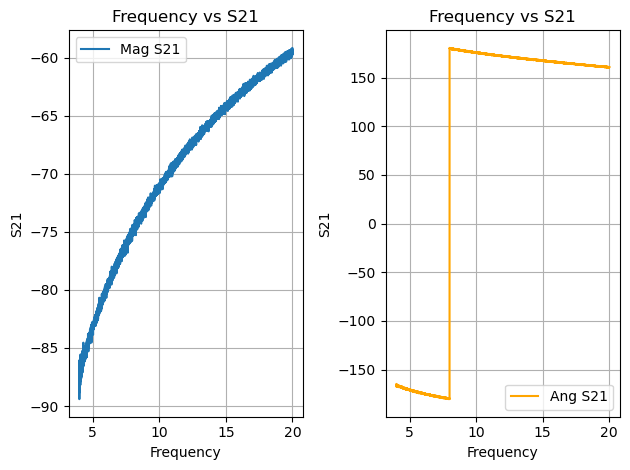

In [7]:
df_pink = add_pink_noise(df)
df_pink = add_pink_noise(df_pink, column='AngS21')

plot_S21(df_pink)

## Quick Test of Lmfit with Evaluated Data (not AWR)
#### The goal here is to generate some fake data with known parameters Q and Qc, and then let lmfit try to find them with only some constraints. f0 needs to have strict bounds otherwise lmfit will return NaN every single time... a sharp resonance is basically impossible for any fitting algorithm to find in any reasonable time

#### We also fit only to the real component of S21 since that is where the majority of our information about Q/Qc is. The imaginary component tells us about the phase asymmetry, which can either be reintroduced later or added artifically



In [12]:
from lmfit import Model, Parameters

def s21_hangarmode_real(f, f0, Q, Qc):
    # equation to be modeled
    s21 = 1 - (Q/Qc)/(1 + 2j*Q*(f/f0 - 1)) 

    return np.real(s21)

s21_model = Model(s21_hangarmode_real)

######### prepare arrays for fitting
freq = df['!Freq']*1e9
resonance_idx = df['AngS21'].argmax()

ampl = 10**(df['DBS21']/20)  # convert S21 dBm to linear
real = np.real(ampl)
f0_guess = freq[resonance_idx]  # convert GHz to Hz
print(f0_guess)

######### simulated data parameters
Q_val = 520000
Qc_val = 30000

fake_freq = np.linspace(7.91e9, 8.09e9, 50000)
fake_vals = s21_model.eval(Q=Q_val, Qc=Qc_val, f0=f0_guess, f=fake_freq)


######### create parameter object for Lmfit
params = Parameters()
params.add('f0', f0_guess, min=f0_guess, max=f0_guess+1 )  # do not want this to vary at all
params.add('Q',  min=1e4, max=1e8) # sensible lower/upper bounds
params.add('Qc', min=1e3, max=1e7)
params['f0'].vary = False

######### perform fit, display results
result = s21_model.fit(fake_vals, params, f=fake_freq)

# I forget how to do it in python
print("Param, Fit Value, Actual Value, Accuracy")  
for key, val in result.best_values.items():
    # i'm sure there's a better way to do this...
    if key == 'Q':   
        given_val = Q_val      
        diff = val - given_val
    elif key == 'Qc':
        given_val = Qc_val
        diff = val - given_val
    else:
        given_val = f0_guess
        diff = val - f0_guess

    print("{}      {:2.2e}      {:2.2e}      {}%".format(key, val, given_val, (val-diff)/val*100))



8004000000.0
Param, Fit Value, Actual Value, Accuracy
f0      8.00e+09      8.00e+09      100.0%
Q      5.20e+05      5.20e+05      99.99999999295737%
Qc      3.00e+04      3.00e+04      99.99999980264671%


[[Model]]
    Model(s21_hangarmode_real)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 50000
    # variables        = 2
    chi-square         = 3.7917e-15
    reduced chi-square = 7.5837e-20
    Akaike info crit   = -2201283.26
    Bayesian info crit = -2201265.62
[[Variables]]
    f0:  8.004e+09 (fixed)
    Q:   520000.000 +/- 9.0311e-06 (0.00%) (init = 10000)
    Qc:  30000.0001 +/- 3.6802e-07 (0.00%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Qc) = 0.707


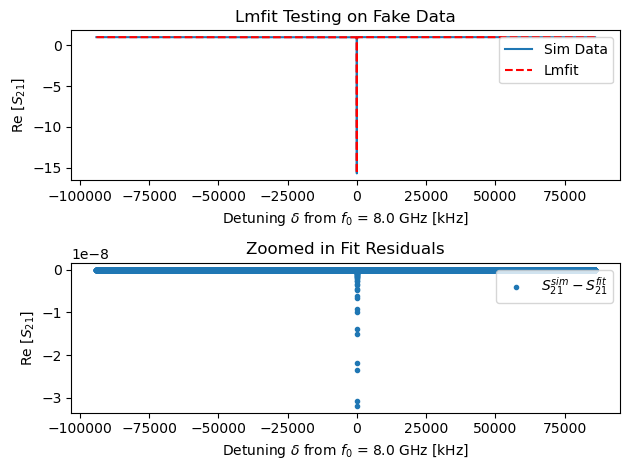

In [10]:
""" plot for simulation above """
######### prepare fake data and start plot
fig1, (ax1, ax2) = plt.subplots(2,1)
# fig1, ax1 = plt.subplots(1)
ax1.plot((fake_freq - f0_guess)/1e3, fake_vals, label='Sim Data')
ax1.set_title("Lmfit Testing on Fake Data")

ax1.plot((fake_freq - f0_guess)/1e3, result.best_fit, linestyle='--', color='red', label='Lmfit')


ax1.legend()

#########
residuals = fake_vals - result.best_fit
ax2.scatter((fake_freq - f0_guess)/1e3, residuals, label='$S_{21}^{sim} - S_{21}^{fit}$', marker='.')
ax2.set_title("Zoomed in Fit Residuals")
ax2.legend()

# ax2.axhline(0)

######### print some values before plot is shown
# print("Model Parameters:")
# display(params)
print(result.fit_report())
ax1.set_xlabel("Detuning $\delta$ from $f_0$ = {:1.1f} GHz [kHz]".format(f0_guess/1e9))
ax1.set_ylabel("Re [$S_{21}$]")
ax2.set_xlabel("Detuning $\delta$ from $f_0$ = {:1.1f} GHz [kHz]".format(f0_guess/1e9))
ax2.set_ylabel("Re [$S_{21}$]")

# zoom_span = 0.1e6
# ax1.set_xlim(np.array([-zoom_span*5/1e3,   zoom_span*5/1e3]))
# ax2.set_xlim(np.array([-zoom_span/1e3, zoom_span/1e3]))

fig1.tight_layout()

### Dynamic Fitting

##### The goal here is to perform the same fitting operation on a given set of data with the ability to modify: subset of data used, fitting parameters, and fitting method employed. Therefore, we construct a generic dynamic_fit() method that has input parameters for all of the above. In the future, we should probably try to do a more OOP approach and create a "dataset" class, with generic class functions, and then that will give us the ability to create methods that rely on using this "dataset" object directly. This would streamline what inputs & outputs are expected on what side of the ("data" <-> "fit method" <-> "fit result") pipeline.